#Pre

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+git://github.com/stared/livelossplot.git
!pip install python_speech_features

In [101]:
from scipy.signal import butter , filtfilt

import os
import pandas as pd
import librosa
import librosa.display
import glob 
import matplotlib.pyplot as plt
import python_speech_features
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import os, fnmatch

import numpy as np
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import classification_report, accuracy_score
import itertools
from keras.layers import TimeDistributed, Bidirectional

from livelossplot import PlotLossesKeras # To plot the NN realtime!

from tqdm import tqdm
import scipy

import csv
import wave
import struct
import pywt

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
PATH_A = '/content/drive/MyDrive/heartbeat-sounds2/set_a'
PATH_B = '/content/drive/MyDrive/heartbeat-sounds2/set_b'
MAX_AUDIO_DURATION = 12

flitflit:
Apply a digital filter forward and backward to a signal.

This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original.

In [6]:
# LPF compressed
def LPF(signal):    
    fc =300
    sr = 22050
    w = fc/(sr/2)
    b,a = butter(3,w , btype = "lowpass")

    x = filtfilt(b,a, signal)
    x = x/x.max()

    return x

In [7]:
# Normalize Data
def audio_norm(data):
    data = (data-min(data))/(max(data)-min(data)+0.0001)
    return data-0.5

In [8]:
# set_a_f_pathes[0].split("/")[-1].split("_")[0]

In [9]:
# set_a_f_pathes[0].split("/")

In [10]:
def get_filenames(path):
    files = []
    for file in glob.glob(path + "/*"):
        if file.split("/")[-1].split("_")[0] not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
            files.append(file.split("/")[-1])
    return files

In [11]:
def get_v_pathes(pathes):
    files = []
    for file in pathes:
        if file.split("/")[-1].split("_")[0] not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
            files.append(file)
    return files

In [12]:
def get_mfcc_LSTM(file_pathes, duration = MAX_AUDIO_DURATION, sr=22050, n_of_mfcc = 40):

    
    # function to load files and extract feature
    data = []
    for file_path in tqdm(file_pathes):

        # try:
        signal, sr = librosa.load( file_path, sr=sr, duration=duration,res_type='kaiser_fast') #duration=duration
        signal_norm = audio_norm(signal)
        X = LPF(signal_norm)
        mfccs = np.mean(  librosa.feature.mfcc(y = X, sr=sr, n_mfcc = n_of_mfcc).T  ,  axis=0)
        # except Exception as e:
        # print("Error encountered while parsing file: ", file_name)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    
    return data

In [13]:
import os, sys
def splitall(path):
    allparts = []
    while 1:
        parts = os.path.split(path)
        if parts[0] == path:  # sentinel for absolute paths
            allparts.insert(0, parts[0])
            break
        elif parts[1] == path: # sentinel for relative paths
            allparts.insert(0, parts[1])
            break
        else:
            path = parts[0]
            allparts.insert(0, parts[1])
    return allparts

In [14]:
set_a_f_pathes = glob.glob("/content/drive/MyDrive/heartbeat-sounds2/set_a/*")
set_a_f_pathes = get_v_pathes(set_a_f_pathes)
a_files  = get_filenames(PATH_A)

set_b_f_pathes = glob.glob("/content/drive/MyDrive/heartbeat-sounds2/set_b/*")
set_b_f_pathes = get_v_pathes(set_b_f_pathes)
b_files  = get_filenames(PATH_B)


In [43]:
# F1

def get_dwt(file_pathes,duration = MAX_AUDIO_DURATION, sr=22050,factor = 10):
    len_list = []
    x_data = []
    for file_path in file_pathes:
        signal, sr = librosa.load( file_path, sr=sr, duration=duration,res_type='kaiser_fast') #duration=duration
        # dow_signal = scipy.signal.decimate(signal,factor)
        signal_norm = audio_norm(signal)
        # filterd = LPF(signal_norm)
        x_data.append(np.array(pywt.dwt(signal_norm,'db4'))[0])
        len_list.append(len(x_data))
    min_length = min(map(len, x_data))
    x_data = np.array([x[:min_length] for x in x_data])
    x_data = np.array([x/max(np.abs(x)) for x in x_data])
    return x_data, sr, len_list



#Functions


In [16]:
def moreNsecs(file, N):
	"""Ignores all entries that are less than N seconds"""
	
	f = wave.open(file)
	frames = f.readframes(-1)
	samples = struct.unpack('h'*f.getnframes(), frames)
	framerate = f.getframerate()
	t = [float(i)/framerate for i in range(len(samples))]
	if t[-1] > 2:
		return True
	else:
		return False

def get_framerate(file):
	"""Returns framerate"""
	f = wave.open(file)
	return f.getframerate()

def get_setA_file_label(N):
	"""Returns set a file and label"""
	"""Input: N - minimum file length"""

	x_trainAFile = [] # wave filename 
	y_trainA = [] # label 
	framerate = [] #frame rate
	with open('set_a.csv') as csvfile:
		reader = csv.reader(csvfile)
		for row in reader:
			if not row[2]=='' and not row[2]=='label':
				if moreNsecs(row[1],2):
					x_trainAFile.append(row[1])
					y_trainA.append(row[2])
					framerate.append(get_framerate(row[1]))
	return np.array(x_trainAFile), np.array(y_trainA), np.array(framerate)

def get_setA_testfile(N):
	x_testFile = []
	with open('set_a.csv') as csvfile:
		reader = csv.reader(csvfile)
		for row in reader:
			if row[2]=='':
				f_name = row[1][:6] + 'Aunlabelledtest' + row[1][6:]
				x_testFile.append(f_name)
	return np.array(x_testFile)

def get_setB_file_label(N):
	"""Returns set b file and label"""
	"""Input: N - minimum file length"""

	x_trainBFile = [] # wave filename 
	y_trainB = [] # label 
	framerate = []

	with open('set_b.csv') as csvfile:
	    reader = csv.reader(csvfile)
	    for row in reader:
		    if not row[2]=='' and not row[2]=='label': #and 'noisy' not in row[1]:
		    	fname = 'set_b/' + row[1][16:]
		    	new_fname = ''
		    	count = 0
		    	for c in fname:
		    		new_fname += c
		    		if c == '_' and 'noisy' not in row[1]:
		    			if count == 1:
		    				new_fname += '_' 
		    			count += 1
		    	if moreNsecs(new_fname,2):
		    		x_trainBFile.append(new_fname)
		    		y_trainB.append(row[2])
		    		framerate.append(get_framerate(new_fname))
	return np.array(x_trainBFile), np.array(y_trainB), np.array(framerate)

def get_signal(file):
	"""Returns the signal from the file"""
	f = wave.open(file)
	frames = f.readframes(-1)
	samples = struct.unpack('h'*f.getnframes(), frames)
	return samples

def get_raw_data(x_trainFile):
	"""Gets the raw x training data"""

	raw_data = []
	for i in range(len(x_trainFile)):
		raw_data.append(np.array(get_signal(x_trainFile[i])))
	return np.array(raw_data)

def down_sample(x, factor=10):
	"""Downsample one sample by a factor of N"""

	r = range(len(x))
	down_array = []
	for i in r[0::factor]:
		down_array.append(x[i])
	return np.array(down_array)

def min_length(filenames):
	data = get_raw_data(filenames)
	return min(map(len, data))

def get_preprocessed_data(set_name, N=2, factor=10):
	"""Get preprocessing data and label for a set"""
	"""Inputs: 
		set_name - either A or B
		N - minimum file sound length (seconds)
		factor - downsample factor"""
	filenames = []
	y_label = []
	framerates =[]

	if set_name.upper() == 'A':
		filenames, y_label, framerates = get_setA_file_label(N)
	else:
		filenames, y_label, framerates = get_setB_file_label(N)
	raw_data = get_raw_data(filenames) #get raw sound data 
	x_data = np.array([down_sample(sample, factor=factor) for sample in raw_data]) #downsample 
	x_data = np.array([pywt.dwt(x,'db4')[0] for x in x_data]) #wavelet decomposition

	min_length = min(map(len, x_data))
	x_data = np.array([x[:min_length] for x in x_data]) #make all data the same length
	x_data = np.array([x/max(np.abs(x)) for x in x_data]) #normalize all data
	return x_data, y_label, framerates

def get_test_data(set_name, N=2, factor=10):
	filenames = []

	if set_name.upper() == 'A':
		filenames = get_setA_testfile(N)
	else:
		return 'Currently not available'
	raw_data = get_raw_data(filenames)
	x_data = np.array([down_sample(sample, factor=factor) for sample in raw_data]) #downsample 
	x_data = np.array([pywt.dwt(x,'db4')[0] for x in x_data]) #wavelet decomposition
	x_data = np.array([x/max(np.abs(x)) for x in x_data]) #normalize all data
	return x_data

In [17]:
from scipy.signal import find_peaks_cwt
def find_peaks(samples, set_name):
    """Gets a list of peaks for each sample"""
    if set_name.upper() == "A":
        interval = 200
        r = 5
    else:
        interval = 20
        r = 2
    all_peaks = []
    for sample in samples:
        indexes = find_peaks_cwt(sample, np.arange(1, r))
        peaks = []
        for i in indexes:
            if sample[i] > 0.15:
                peaks.append(i)
        if len(peaks) > 1:
            i = 1
            start = 0
            tmp_array = []
            max_peak = sample[peaks[start]]
            max_ind = start
            while i < len(peaks):
                if peaks[i] <= (peaks[start] + interval):
                    if sample[peaks[i]] > max_peak:
                        max_peak = sample[peaks[i]]
                        max_ind = i
                    if i == len(peaks)-1:
                        tmp_array.append(peaks[max_ind])
                        break
                    i += 1
                else:
                    tmp_array.append(peaks[max_ind])
                    start = i
                    max_ind = start
                    max_peak = sample[peaks[start]]
                i += 1
            peaks = tmp_array
        all_peaks.append(peaks)
    return np.array(all_peaks)

In [18]:
##Function 3 Finding S1 and S2 bounds

def get_S1S2_bounds(data, peaks, set_name):
    
    #finding difference between all peaks in every file
    all_diffs = []
    for k in range(len(peaks)):
        diff = np.diff(peaks[k])
        all_diffs.append(diff)

    #finding max difference or diastole period  and then labelling the first peak as s2 and second peak as s1
    max_index = []
    s1s2_peaks = []
    for k in range(len(all_diffs)):
        if any(all_diffs[k]):
            max_index.append(np.argmax(all_diffs[k]))
            s2 = peaks[k][max_index[k]]
            s1 = peaks[k][max_index[k]+1]
            s1s2_peaks.append([s1, s2])
        else:
            max_index.append(-1)
            s1s2_peaks.append([-1,-1])
    s1s2_peaks = np.array(s1s2_peaks)

    #defining s1 and s2 boundaries
    s1_bounds = []
    s2_bounds = []
    if set_name == 'A':
        upper_s1 = 200*2
        lower_s1 = 80*2
        upper_s2 = 600*2
        lower_s2 = 70*2
    else:
        upper_s1 = 25*10
        lower_s1 = 10*10
        upper_s2 = 35*10
        lower_s2 = 10*10

    for k in range(len(s1s2_peaks)):
        if s1s2_peaks[k][0] == -1:
            s1_bounds.append([-1,-1])
            s2_bounds.append([-1,-1])
        else:
            s1_lower = s1s2_peaks[k][0]-lower_s1
            s1_upper = s1s2_peaks[k][0]+upper_s1
            s2_lower = s1s2_peaks[k][1]-lower_s2
            s2_upper = s1s2_peaks[k][1]+upper_s2
            if s1_lower < 0:
                s1_lower = 0
            if s2_lower < 0:
                s2_lower = 0
            if s1_upper >= len(data[0]):
                s1_upper = len(data[0]) - 1
            if s2_upper >= len(data[0]):
                s2_upper = len(data[0]) - 1
            s1_bounds.append([s1_lower,s1_upper])
            s2_bounds.append([s2_lower,s2_upper])

    return np.array(s1_bounds),np.array(s2_bounds), all_diffs

#Defs

In [19]:
def conf_plotter(y_true, y_pred, classes,
                      normalize=0,
                      title=None,
                      cmap=plt.cm.pink_r,
                      mode = 'train',
                      save = 0,
                      name = 'conf.jpg'):

    # if not title:
    #     if mode == 'train':
    #         title = 'Normalized confusion matrix on train dataset'
    #     if mode == 'test':
    #         title = 'Normalized confusion matrix on test dataset'
    #     if mode == 'prob':
    #         title = 'Normalized confusion matrix on Non-Overlapping test dataset'
            

    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax ,fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(cm.shape[0]),
           yticks=np.arange(cm.shape[1]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel= 'True label',
           xlabel='Predicted label')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ):
                    
        item.set_fontsize(12)
     
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        
        item.set_fontsize(10)

        
                
    plt.gca().invert_yaxis()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save == 1:
        plt.savefig(name)
    return ax

In [20]:
eps = 0.00000001

def stZCR(frame):
   # computing zero crossing rate
   count = len(frame)
   count_z = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
   return (np.float64(count_z) / np.float64(count - 1))


def stEnergy(frame):
   return (np.sum(frame ** 2) / np.float64(len(frame)))



def stEnergyEntropy(frame, n_short_blocks=10):
    """Computes entropy of energy"""
    Eol = numpy.sum(frame ** 2)    # total frame energy
    L = len(frame)
    sub_win_len = int(numpy.floor(L / n_short_blocks))
    if L != sub_win_len * n_short_blocks:
            frame = frame[0:sub_win_len * n_short_blocks]
    # sub_wins is of size [n_short_blocks x L]
    sub_wins = frame.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = numpy.sum(sub_wins ** 2, axis=0) / (Eol + eps)

    # Compute entropy of the normalized sub-frame energies:
    Entropy = -numpy.sum(s * numpy.log2(s + eps))
    return Entropy


def stSpectralEntropy(X, n_short_blocks=10):
    """Computes the spectral entropy"""
    L = len(X)                         # number of frame samples
    Eol = numpy.sum(X ** 2)            # total spectral energy

    sub_win_len = int(numpy.floor(L / n_short_blocks))   # length of sub-frame
    if L != sub_win_len * n_short_blocks:
        X = X[0:sub_win_len * n_short_blocks]

    sub_wins = X.reshape(sub_win_len, n_short_blocks, order='F').copy()  # define sub-frames (using matrix reshape)
    s = numpy.sum(sub_wins ** 2, axis=0) / (Eol + eps)                      # compute spectral sub-energies
    En = -numpy.sum(s*numpy.log2(s + eps))                                    # compute spectral entropy

    return En

def stSpectralFlux(X, Xprev):
    """
    Computes the spectral flux feature of the current frame
    ARGUMENTS:
        X:        the abs(fft) of the current frame
        Xpre:        the abs(fft) of the previous frame
    """
    # compute the spectral flux as the sum of square distances:
    sumX = numpy.sum(X + eps)
    sumPrevX = numpy.sum(Xprev + eps)
    F = numpy.sum((X / sumX - Xprev/sumPrevX) ** 2)

    return F

def stSpectralCentroidAndSpread(X, fs):
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (numpy.arange(1, len(X) + 1)) * (fs/(2.0 * len(X)))

    Xt = X.copy()
    Xt = Xt / Xt.max()
    NUM = numpy.sum(ind * Xt)
    DEN = numpy.sum(Xt) + eps

    # Centroid:
    C = (NUM / DEN)

    # Spread:
    S = numpy.sqrt(numpy.sum(((ind - C) ** 2) * Xt) / DEN)

    # Normalize:
    C = C / (fs / 2.0)
    S = S / (fs / 2.0)

    return (C, S)


def freqInterval(data,lower,l_index,upper,u_index):
    freq = []
    for i in range(len(data)):
        if lower[i][0] == -1:
            freq.append(0)
        else:
            temp = data[i][lower[i][l_index]:upper[i][u_index]]
            temp = np.fft.fft(temp)
            temp = np.abs(temp)/max(np.abs(temp))
            #freq.append(temp[:int(len(temp)/2)])
            freq.append(temp)
    return np.array(freq)




In [21]:
## Function 4. Getting standard deviation interval

def stdInterval(lower, low_index, upper, up_index, data):
    std = []
    for k in range(len(data)):
        if lower[k][0] == -1:
            std.append(0)
        else:
            dev = np.std(data[k][lower[k][low_index]:upper[k][up_index]])
            if np.isnan(dev):
                std.append(0)
            else:
                std.append(dev)
    return np.array(std)

#  Etxra Features
 
# 1. number of peaks
# 2. average timing between peaks  
# 3. average strength of peaks 
# 4. min peak
# 5. max peak

In [ ]:
def get_features(x_train,all_peaks):
    features = []
    for k in range(len(all_peaks)): 
        num_peaks = len(all_peaks[k])
        avg_between = 0
        avg_strength = 0
        if len(all_peaks[k]) == 1:
            avg_strength = x_train[k][all_peaks[k]]
        min_peak = 0
        max_peak = 0
        if num_peaks > 1:
            for i in range(1,len(all_peaks[k])):
                avg_between += np.abs(all_peaks[k][i] - all_peaks[k][i-1])
            avg_between /= len(all_peaks[k]) - 1
            min_peak = min(x_train[n][all_peaks[k]])
            max_peak = max(x_train[n][all_peaks[k]])
            for i in range(1,len(all_peaks[k])):
                avg_strength += x_train[n][all_peaks[k][i]]
            avg_strength /= len(all_peaks[k])
        features.append([num_peaks,avg_between,avg_strength,min_peak,max_peak])
    features = np.array(features)
    maxes = np.amax(features,axis=0)
    for feature in features:
        feature = np.array([feature[0]/maxes[0],feature[1]/maxes[1],feature[2]/maxes[2],feature[3]/maxes[3],feature[4]/maxes[4]])
    return features 



In [ ]:
# dont run
x_dataB.shape , x_dataA.shape # shape for with dowm__sampling

((461, 845), (84, 1036))

In [ ]:
x_dataB.shape , x_dataA.shape 

((461, 8418), (84, 10327))

#Archive


In [ ]:
# def chroma_stft(file_pathes, duration = MAX_AUDIO_DURATION, sr=22050, n_chroma = 12):

    
#     # function to load files and extract feature
#     data = []
#     for file_path in tqdm(file_pathes):

#         # try:
#         signal, sr = librosa.load( file_path, sr=sr, duration=duration,res_type='kaiser_fast') #duration=duration
#         signal_norm = audio_norm(signal)
#         X = LPF(signal_norm)
#         chroma_stft = np.mean(  librosa.feature.chroma_stft(y = X, sr=sr, n_chroma = n_chroma).T  ,  axis=0)
#         # except Exception as e:
#         # print("Error encountered while parsing file: ", file_name)
#         feature = np.array(chroma_stft).reshape([-1,1])
#         data.append(feature)
#     return data

In [ ]:
def chroma_cq(file_pathes, duration = MAX_AUDIO_DURATION, sr=22050, n_chroma = 12):

    
    # function to load files and extract feature
    data = []
    for file_path in tqdm(file_pathes):

        # try:
        signal, sr = librosa.load( file_path, sr=sr, duration=duration,res_type='kaiser_fast') #duration=duration
        signal_norm = audio_norm(signal)
        X = LPF(signal_norm)
        chroma_cq = np.mean(librosa.feature.chroma_cqt(y=X, sr=sr).T,  axis=0)
        # except Exception as e:
        # print("Error encountered while parsing file: ", file_name)
        feature = np.array(chroma_cq).reshape([-1,1])
        data.append(feature)
    return data

In [ ]:
def chroma_cens(file_pathes, duration = MAX_AUDIO_DURATION, sr=22050, n_chroma = 12):

    
    # function to load files and extract feature
    data = []
    for file_path in tqdm(file_pathes):

        # try:
        signal, sr = librosa.load( file_path, sr=sr, duration=duration,res_type='kaiser_fast') #duration=duration
        signal_norm = audio_norm(signal)
        X = LPF(signal_norm)
        chroma_cens = np.mean(librosa.feature.chroma_cens(y=X, sr=sr).T,  axis=0)
        # except Exception as e:
        # print("Error encountered while parsing file: ", file_name)
        feature = np.array(chroma_cens).reshape([-1,1])
        data.append(feature)
    return data

In [ ]:
def melspectrogram(file_pathes, duration = MAX_AUDIO_DURATION, sr=22050, n_mels= 128 ):

    
    # function to load files and extract feature
    data = []
    for file_path in tqdm(file_pathes):

        # try:
        signal, sr = librosa.load( file_path, sr=sr, duration=duration,res_type='kaiser_fast') #duration=duration
        signal_norm = audio_norm(signal)
        X = LPF(signal_norm)
        melspectrogram = np.mean(librosa.feature.melspectrogram(y=X, sr=sr, n_mels= n_mels).T,  axis=0)

        # except Exception as e:
        # print("Error encountered while parsing file: ", file_name)
        feature = np.array(melspectrogram).reshape([-1,1])
        data.append(feature)
    return data

In [ ]:
def sd_spectral_centroid(file_pathes, duration = MAX_AUDIO_DURATION, sr=22050):

    
    # function to load files and extract feature
    data = []
    for file_path in tqdm(file_pathes):

        # try:
        signal, sr = librosa.load( file_path, sr=sr, duration=duration,res_type='kaiser_fast') #duration=duration
        signal_norm = audio_norm(signal)
        X = LPF(signal_norm)
        cent = stdev(librosa.feature.spectral_centroid(y=X, sr=sr).T)
        


        # except Exception as e:
        # print("Error encountered while parsing file: ", file_name)
        feature = np.array(cent).reshape([-1,1])
        data.append(feature)
    return data

# Librosa Features


In [22]:
import statistics as st
import math
def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
def stdev(data):
    var = variance(data)
    std_dev = math.sqrt(var)
    return std_dev
# Also statistics module to calculate sd
# st.pstdev()

In [24]:
def clean(file_pathes,duration = MAX_AUDIO_DURATION, sr=22050):

    Cleaned = []

    for file_path in tqdm(file_pathes):

        # try:
        signal, sr = librosa.load( file_path, sr=sr, duration=duration,res_type='kaiser_fast') #duration=duration
        signal_norm = audio_norm(signal)
        # X = LPF(signal_norm)
        Cleaned.append(signal_norm)

    return Cleaned

In [168]:
def get_features(s ,sr = 22050, n_chroma = 12, n_mels= 128, n_order= 2,  n_fft=2048 * 2):
    # data_chroma_stft = []
    data_chroma_cq =[]
    data_chroma_cens =[]
    data_sd_spectral_centroid =[]
    data_m_poly = []
    data_sd_poly= []
    data_sd_contrast = []
    data_sd_rolloff = []
    data_sd_flatness = []
    data_sd_bw = []
    data_melspectrogram = []
    data_fbank= []
    data_ssc = []
    for i in tqdm(range(len(s))):

        # chroma_stft_pre = np.mean(  librosa.feature.chroma_stft(y = s[i], sr=sr, n_chroma = n_chroma).T  ,  axis=0)
        # chroma_stft = np.array(chroma_stft_pre).reshape([-1,1])

        fbank = np.mean(python_speech_features.logfbank(s[i] , samplerate=sr , nfilt=40 , nfft=1024*2) , axis=0)
        fbank = fbank.reshape([-1,1])
       
        ssc = np.mean(python_speech_features.base.ssc(s[i] ,samplerate=sr,nfft = 1024*2) , axis=0)
        ssc = ssc.reshape([-1,1])
      
        chroma_cq_pre = np.mean(librosa.feature.chroma_cqt(y=s[i], sr=sr).T,  axis=0)
        chroma_cq = np.array(chroma_cq_pre).reshape([-1,1])

        chroma_cens_pre = np.mean(librosa.feature.chroma_cens(y=s[i], sr=sr).T,  axis=0)
        chroma_cens = np.array(chroma_cens_pre).reshape([-1,1])

        melspectrogram_pre = np.mean(librosa.feature.melspectrogram(y=s[i], sr=sr, n_mels= n_mels, n_fft=n_fft).T,  axis=0)
        melspectrogram = np.array(melspectrogram_pre).reshape([-1,1])

        cent = stdev(librosa.feature.spectral_centroid(y=s[i], sr=sr,n_fft=n_fft).T)


        p = librosa.feature.poly_features(S= np.abs(librosa.stft(s[i])), order=n_order).T
        m_poly = np.mean(p)

        for i in range(n_order):
            data_sd_poly.append(stdev(p[i]))


        
        b = librosa.feature.spectral_bandwidth(s[i], n_fft=n_fft)
        sd_bw = stdev(b[0])

        
        contrast = librosa.feature.spectral_contrast(S=np.abs(librosa.stft(s[i])), sr=sr,n_fft=n_fft)
        
        for i in range(len(contrast)):
            data_sd_contrast.append(stdev(contrast[i]))

        flatness = librosa.feature.spectral_flatness(y= s[i],n_fft=n_fft)
        sd_flatness = stdev(flatness[0])

        rolloff = librosa.feature.spectral_rolloff(y=s[i], sr=sr, roll_percent=0.85,n_fft=n_fft).T
        sd_roll = stdev(rolloff)

        data_fbank.append(fbank)
        data_ssc.append(ssc)
        data_chroma_cq.append(chroma_cq)
        data_chroma_cens.append(chroma_cens)
        data_melspectrogram.append(melspectrogram)
        data_sd_spectral_centroid.append(cent)
        data_m_poly.append(m_poly)
        data_sd_bw.append(sd_bw)
        data_sd_flatness.append(sd_flatness)
        data_sd_rolloff.append(sd_roll)


    return data_fbank, data_ssc, data_chroma_cq, data_chroma_cens, data_melspectrogram, data_sd_spectral_centroid, data_m_poly, data_sd_poly, data_sd_bw, data_sd_contrast, data_sd_flatness, data_sd_rolloff

In [ ]:
SignalsA = clean(set_a_f_pathes)
SignalsB = clean(set_b_f_pathes)

In [ ]:
data_fbankA, data_sscA, data_chroma_cqA, data_chroma_censA, data_melspectrogramA, data_sd_spectral_centroidA, data_m_polyA, data_sd_polyA, data_sd_bwA, data_sd_contrastA, data_sd_flatnessA, data_sd_rolloffA  = get_features(SignalsA)

arr_data_fbankA = np.array(data_fbankA)
arr_data_sscA = np.array(data_sscA)

arr_chroma_cqA = np.array(data_chroma_cqA)
arr_chroma_censA = np.array(data_chroma_censA)
arr_melspectrogramA = np.array(data_melspectrogramA)
arr_sd_spectral_centroidA = np.array(data_sd_spectral_centroidA)
arr_m_polyA = np.array(data_m_polyA)
arr_sd_polyA = np.array(data_sd_polyA)
arr_sd_bwA = np.array(data_sd_bwA)
arr_sd_contrastA = np.array(data_sd_contrastA)
arr_sd_flatnessA = np.array(data_sd_flatnessA)
arr_sd_rolloffA = np.array(data_sd_rolloffA)

arr_sd_spectral_centroidA = arr_sd_spectral_centroidA.reshape([84,-1,1])
arr_m_polyA = arr_m_polyA.reshape([84,-1,1])
arr_sd_polyA = arr_sd_polyA.reshape([84,-1,1])
arr_sd_bwA = arr_sd_bwA.reshape([84,-1,1])
arr_sd_contrastA = arr_sd_contrastA.reshape([84,-1,1])
arr_sd_flatnessA = arr_sd_flatnessA.reshape([84,-1,1])
arr_sd_rolloffA = arr_sd_rolloffA.reshape([84,-1,1])



In [ ]:
data_fbankB, data_sscB, data_chroma_cqB, data_chroma_censB, data_melspectrogramB, data_sd_spectral_centroidB, data_m_polyB, data_sd_polyB, data_sd_bwB, data_sd_contrastB, data_sd_flatnessB, data_sd_rolloffB  = get_features(SignalsB)

arr_data_fbankB = np.array(data_fbankB)
arr_data_sscB = np.array(data_sscB)

arr_chroma_cqB = np.array(data_chroma_cqB)
arr_chroma_censB = np.array(data_chroma_censB)
arr_melspectrogramB = np.array(data_melspectrogramB)
arr_sd_spectral_centroidB = np.array(data_sd_spectral_centroidB)
arr_m_polyB = np.array(data_m_polyB)
arr_sd_polyB = np.array(data_sd_polyB)
arr_sd_bwB = np.array(data_sd_bwB)
arr_sd_contrastB = np.array(data_sd_contrastB)
arr_sd_flatnessB = np.array(data_sd_flatnessB)
arr_sd_rolloffB = np.array(data_sd_rolloffB)

arr_sd_spectral_centroidB = arr_sd_spectral_centroidB.reshape([461,-1,1])
arr_m_polyB = arr_m_polyB.reshape([461,-1,1])
arr_sd_polyB = arr_sd_polyB.reshape([461,-1,1])
arr_sd_bwB = arr_sd_bwB.reshape([461,-1,1])
arr_sd_contrastB = arr_sd_contrastB.reshape([461,-1,1])
arr_sd_flatnessB = arr_sd_flatnessB.reshape([461,-1,1])
arr_sd_rolloffB = arr_sd_rolloffB.reshape([461,-1,1])


In [162]:
print(arr_data_fbankA.shape)
print(arr_data_sscA.shape)
print(arr_chroma_cqA.shape)
print(arr_chroma_censA.shape)
print(arr_melspectrogramA.shape)
print(arr_sd_spectral_centroidA.shape)
print(arr_m_polyA.shape)
print(arr_sd_polyA.shape)
print(arr_sd_bwA.shape)
print(arr_sd_contrastA.shape)
print(arr_sd_flatnessA.shape)
print(arr_sd_rolloffA.shape)


(84, 40, 1)
(84, 26, 1)
(84, 12, 1)
(84, 12, 1)
(84, 128, 1)
(84, 1, 1)
(84, 1, 1)
(84, 2, 1)
(84, 1, 1)
(84, 7, 1)
(84, 1, 1)
(84, 1, 1)


In [ ]:

data = []
sr = 22050

signal, sr = librosa.load( set_a_f_pathes[0],sr = sr, duration=12,res_type='kaiser_fast') #duration=duration
signal_norm = audio_norm(signal)
X = LPF(signal_norm)
data_sd_poly = []
p = librosa.feature.poly_features(S= np.abs(librosa.stft(X)), order=2).T
m_poly = np.mean(p)

for i in range(2):
    data_sd_poly.append(stdev(p[i]))


# stdev(p[])
# melspectrogram = librosa.feature.melspectrogram(y=X, sr=sr, n_mels= 128).T
# mfccs = np.mean(  librosa.feature.mfcc(y = X, sr=sr, n_mfcc = n_of_mfcc).T  ,  axis=0)
# except Exception as e:
# print("Error encountered while parsing file: ", file_name)
# feature = np.array(mfccs).reshape([-1,1])
# data.append(feature)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


#coding

In [44]:
x_dataA, srA, len_listA = get_dwt(set_a_f_pathes)
x_dataB, srB, len_listB = get_dwt(set_b_f_pathes)

In [45]:
dataA_peaks = find_peaks(x_dataA,"A")
# s1_boundsA, s2_boundsA = get_S1S2_bounds(x_dataA,dataA_peaks,"A")

# s1_boundsB, s2_boundsB, _ = get_S1S2_bounds(x_dataB,dataB_peaks,"B")
dataB_peaks = find_peaks(x_dataB,"B")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [46]:
##Function 5. Extracting features for set A

# Standard deviation for S1 and S2
s1_boundsA , s2_boundsA, _ = get_S1S2_bounds(x_dataA, dataA_peaks, 'A')

stdS1_A = stdInterval(s1_boundsA,0,s1_boundsA,1,x_dataA)
stdS1_A = stdS1_A/max(stdS1_A)

stdS2_A = stdInterval(s2_boundsA,0,s2_boundsA,1,x_dataA)
stdS2_A = stdS2_A/max(stdS2_A)

# Mean and standard deviation for frequency spectrum of S1 and S2
freqS1_A = freqInterval(x_dataA,s1_boundsA,0,s1_boundsA,1)
stdS1_freqA = np.array([np.std(f) for f in freqS1_A])
stdS1_freqA = stdS1_freqA/max(stdS1_freqA)
meanS1_freqA = np.array([np.average(f) for f in freqS1_A])
meanS1_freqA = meanS1_freqA/max(meanS1_freqA)
freqS2_A = freqInterval(x_dataA,s2_boundsA,0,s2_boundsA,1)
stdS2_freqA = np.array([np.std(f) for f in freqS2_A])
stdS2_freqA = stdS2_freqA/max(stdS2_freqA)
meanS2_freqA = np.array([np.average(f) for f in freqS2_A])
meanS2_freqA = meanS2_freqA/max(meanS2_freqA)

# zero crossing rate of frame
zero_crossingsA = np.array([stZCR(x) for x in x_dataA])
zero_crossingsA = zero_crossingsA/max(zero_crossingsA)

# signal energy of frame
energyA = np.array([stEnergy(x) for x in x_dataA])
energyA = energyA/max(energyA)

# entropy of energy
entropyA = np.array([stEnergyEntropy(x, n_short_blocks=50) for x in x_dataA])
entropyA = entropyA/max(entropyA)

# frequency domain
X_dataA = np.array([np.fft.fft(x) for x in x_dataA])
X_dataA = np.array([np.abs(X)/max(np.abs(X)) for X in X_dataA])

# spectral entropy
entropy_freqA = np.array([stSpectralEntropy(X,n_short_blocks=150) for X in X_dataA])
entropy_freqA = entropy_freqA/max(entropy_freqA)

# # spectral flux
# fluxA = np.array([np.abs(stSpectralFlux(X[:int(len(X)/2)],X[int(len(X)/2):])) for X in X_dataA])
# fluxA = fluxA/max(fluxA)

# spectral centroid of frame (given abs(FFT))
FsA = int(srA/20) 

# framerate is the same for all of set A
centroidA = np.array([stSpectralCentroidAndSpread(np.abs(X),FsA) for X in X_dataA])
centroidA[:,0] = centroidA[:,0]/max(centroidA[:,0])
centroidA[:,1] = centroidA[:,1]/max(centroidA[:,1])

from python_speech_features import mfcc
mfccA = np.array([mfcc(np.abs(x),samplerate=FsA,numcep=3,winlen=0.025) for x in x_dataA])
mfccA_feat = np.array([[np.average(m[:,0]), np.std(m[:,0]), np.average(m[:,1]), np.std(m[:,1]), np.average(m[:,2]),np.std(m[:,2])] for m in mfccA])

for i in range(len(mfccA_feat[0])):
    mfccA_feat[:,i] = np.abs(mfccA_feat[:,i])/max(np.abs(mfccA_feat[:,i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [47]:
##Function 5. Extracting features for set B 




# Standard deviation for S1 and S2
s1_boundsB , s2_boundsB, _n = get_S1S2_bounds(x_dataB, dataB_peaks, 'B')

stdS1_B = stdInterval(s1_boundsB,0,s1_boundsB,1,x_dataB)
stdS1_B = stdS1_B/max(stdS1_B)

stdS2_B = stdInterval(s2_boundsB,0,s2_boundsB,1,x_dataB)
stdS2_B = stdS2_B/max(stdS2_B)

# Mean and standard deviation for frequency spectrum of S1 and S2
freqS1_B = freqInterval(x_dataB,s1_boundsB,0,s1_boundsB,1)
stdS1_freqB = np.array([np.std(f) for f in freqS1_B])
stdS1_freqB = stdS1_freqB/max(stdS1_freqB)
meanS1_freqB = np.array([np.average(f) for f in freqS1_B])
meanS1_freqB = meanS1_freqB/max(meanS1_freqB)
freqS2_B = freqInterval(x_dataB,s2_boundsB,0,s2_boundsB,1)
stdS2_freqB = np.array([np.std(f) for f in freqS2_B])
stdS2_freqB = stdS2_freqB/max(stdS2_freqB)
meanS2_freqB = np.array([np.average(f) for f in freqS2_B])
meanS2_freqB = meanS2_freqB/max(meanS2_freqB)

# zero crossing rate of frame
zero_crossingsB = np.array([stZCR(x) for x in x_dataB])
zero_crossingsB = zero_crossingsB/max(zero_crossingsB)

# signal energy of frame
energyB = np.array([stEnergy(x) for x in x_dataB])
energyB = energyB/max(energyB)

# entropy of energy
entropyB = np.array([stEnergyEntropy(x, n_short_blocks=50) for x in x_dataB])
entropyB = entropyB/max(entropyB)

# frequency domain
X_dataB = np.array([np.fft.fft(x) for x in x_dataB])
X_dataB = np.array([np.abs(X)/max(np.abs(X)) for X in X_dataB])

# spectral entropy
entropy_freqB = np.array([stSpectralEntropy(X,n_short_blocks=150) for X in X_dataB])
entropy_freqB = entropy_freqB/max(entropy_freqB)

# spectral flux


# fluxB = np.array([np.abs(stSpectralFlux(X[:int(len(X)/2)],X[int(len(X)/2):])) for X in X_dataB])
# fluxB = fluxB/max(fluxB)

# spectral centroid of frame (given abs(FFT))
FsB = int(srB/20) 

# framerate is the same for all of set A
centroidB = np.array([stSpectralCentroidAndSpread(np.abs(X),FsA) for X in X_dataB])
centroidB[:,0] = centroidB[:,0]/max(centroidB[:,0])
centroidB[:,1] = centroidB[:,1]/max(centroidB[:,1])

from python_speech_features import mfcc
mfccB = np.array([mfcc(np.abs(x),samplerate=FsB,numcep=3,winlen=0.025) for x in x_dataB])
mfccB_feat = np.array([[np.average(m[:,0]), np.std(m[:,0]), np.average(m[:,1]), np.std(m[:,1]), np.average(m[:,2]),np.std(m[:,2])] for m in mfccB])

for i in range(len(mfccB_feat[0])):
    mfccB_feat[:,i] = np.abs(mfccB_feat[:,i])/max(np.abs(mfccB_feat[:,i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [48]:

labels_A = [] 
len_classes = 3
for file in a_files:
    if 'normal' in file:
        labels_A.append(0)
    elif 'murmur' in file:
        labels_A.append(1)
    elif 'extrastole' in file:
        labels_A.append(2)
    elif 'extrahls' in file:
        labels_A.append(2)

labels_B = [] 
len_classes = 3
for file in b_files:
    if 'normal' in file:
        labels_B.append(0)
    elif 'murmur' in file:
        labels_B.append(1)
    elif 'extrastole' in file:
        labels_B.append(2)
    elif 'extrahls' in file:
        labels_B.append(2)

y_A = np.asarray(labels_A)
y_B = np.asarray(labels_B)


In [49]:
x_utrainA = np.column_stack((zero_crossingsA, energyA, entropyA, entropy_freqA,
                             centroidA[:,1], mfccA_feat, stdS1_A,
                             stdS2_A, stdS1_freqA, meanS1_freqA,
                             stdS2_freqA, meanS2_freqA))

x_utrainB = np.column_stack((zero_crossingsB, energyB, entropyB, entropy_freqB,
                            centroidB[:,1],mfccB_feat,stdS1_B,
                            stdS2_B, stdS1_freqB, meanS1_freqB,
                            stdS2_freqB, meanS2_freqB))

# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# y_utrainA = le.fit_transform(labels_A)
# y_utrainB = le.fit_transform(labels_B)

# from sklearn.utils import shuffle
# # x_trainA, y_trainA = shuffle(x_utrainA,y_utrainA)
# # x_trainB, y_trainB = shuffle(x_utrainB,y_utrainB)

# from sklearn.model_selection import KFold
# kf = KFold(n_splits=4, shuffle=False)

In [50]:
x_utrainA.shape, x_utrainB.shape

((84, 17), (461, 17))

In [51]:
x_utrainA = x_utrainA[:,:,np.newaxis]
x_utrainB = x_utrainB[:,:,np.newaxis]
x_utrainB.shape,x_utrainA.shape


((461, 17, 1), (84, 17, 1))

# MFCC

In [52]:
mfcc_A = get_mfcc_LSTM(set_a_f_pathes,n_of_mfcc=63)
mfcc_B = get_mfcc_LSTM(set_b_f_pathes,n_of_mfcc=63)

100%|██████████| 461/461 [01:06<00:00,  6.98it/s]


In [53]:
mfcc_A = np.array(mfcc_A)
mfcc_B = np.array(mfcc_B)

In [54]:
mfcc_A.shape, mfcc_B.shape

((84, 63, 1), (461, 63, 1))

In [56]:
print(arr_chroma_cqA.shape)
print(arr_chroma_censA.shape)
print(arr_melspectrogramA.shape)
print(arr_sd_spectral_centroidA.shape)
print(arr_m_polyA.shape)
print(arr_sd_polyA.shape)
print(arr_sd_bwA.shape)
print(arr_sd_contrastA.shape)
print(arr_sd_flatnessA.shape)
print(arr_sd_rolloffA.shape)

(84, 12, 1)
(84, 12, 1)
(84, 128, 1)
(84, 1, 1)
(84, 1, 1)
(84, 2, 1)
(84, 1, 1)
(84, 7, 1)
(84, 1, 1)
(84, 1, 1)


In [ ]:
print(arr_data_fbankA.shape)


In [115]:
A = np.concatenate((mfcc_A,arr_data_fbankA,arr_data_sscA, x_utrainA , arr_chroma_cqA, arr_chroma_censA,arr_melspectrogramA, arr_sd_spectral_centroidA, arr_m_polyA, arr_sd_polyA,arr_sd_bwA, arr_sd_contrastA, arr_sd_flatnessA, arr_sd_rolloffA),1)
B = np.concatenate((mfcc_B,arr_data_fbankB,arr_data_sscB, x_utrainB, arr_chroma_cqB, arr_chroma_censB,arr_melspectrogramB, arr_sd_spectral_centroidB, arr_m_polyB, arr_sd_polyB,arr_sd_bwB, arr_sd_contrastB, arr_sd_flatnessB, arr_sd_rolloffB),1)
A.shape, B.shape

((84, 312, 1), (461, 312, 1))

In [ ]:
# A = np.concatenate((mfcc_A,x_utrainA , arr_chroma_cqA, arr_chroma_censA, arr_melspectrogramA, arr_sd_spectral_centroidA, arr_m_polyA, arr_sd_polyA, arr_sd_contrastA, arr_sd_flatnessA, arr_sd_rolloffA),1)
# B = np.concatenate((mfcc_B,x_utrainB, arr_chroma_cqB, arr_chroma_censB, arr_melspectrogramB, arr_sd_spectral_centroidB, arr_m_polyB, arr_sd_polyB, arr_sd_contrastB, arr_sd_flatnessB, arr_sd_rolloffB),1)
# A.shape, B.shape

((84, 245, 1), (461, 245, 1))

In [116]:
All_Data_X = np.concatenate((A,B))
All_Data_X.shape

(545, 312, 1)

In [60]:
All_Data_Y = np.concatenate((y_A,y_B))
All_Data_Y.shape

(545,)

#Augmented Data

In [75]:
import pickle
def get_data(file_list, progress_bar=False):
    def load_into(_filename, _x, _y):
        with open(_filename, 'rb') as f:
            audio_element = pickle.load(f)
            _x.append(audio_element['audio'])
            _y.append(int(audio_element['class_id']))

    x, y = [], []
    for filename in file_list:
        load_into(filename, x, y)
    return np.array(x), np.array(y)

In [70]:
import os

DATA_AUDIO_DIR = './audio'
TARGET_SR = 8000
OUTPUT_DIR = '/content/drive/MyDrive/output2'
OUTPUT_DIR_TRAIN = os.path.join(OUTPUT_DIR, 'train')
OUTPUT_DIR_TEST = os.path.join(OUTPUT_DIR, 'test')
AUDIO_LENGTH = 10000

In [76]:
train_files = glob.glob(os.path.join(OUTPUT_DIR_TRAIN, '**.pkl'))
x_tr, y_tr = get_data(train_files)
# y_tr = to_categorical(y_tr, num_classes=num_classes)

test_files = glob.glob(os.path.join(OUTPUT_DIR_TEST, '**.pkl'))
x_te, y_te = get_data(test_files)
# y_te = to_categorical(y_te, num_classes=num_classes)

In [85]:
aug = np.concatenate((x_te, x_tr), axis = 0)

In [159]:
x_te.shape, x_tr.shape

((111, 10000, 1), (950, 10000, 1))

In [87]:
aug_label = np.concatenate((y_te, y_tr), axis = 0)

In [94]:
aug_label.shape

(1061,)

In [160]:
l_aug = list(aug.reshape([1061,10000]))
l_aug_label = list(aug_label)

In [ ]:
data_fbankAug, data_sscAug, data_chroma_cqAug, data_chroma_censAug, data_melspectrogramAug, data_sd_spectral_centroidAug, data_m_polyAug, data_sd_polyAug, data_sd_bwAug, data_sd_contrastAug, data_sd_flatnessAug, data_sd_rolloffAug  = get_features(l_aug)
arr_data_fbankAug = np.array(data_fbankAug)
arr_data_sscAug = np.array(data_sscAug)
arr_data_chroma_cqAug = np.array(data_chroma_cqAug)
arr_data_chroma_censAug = np.array(data_chroma_censAug)
arr_data_melspectrogramAug = np.array(data_melspectrogramAug)
arr_data_melspectrogramAug = np.array(data_melspectrogramAug)
arr_data_sd_spectral_centroidAug = np.array(data_sd_spectral_centroidAug)
arr_data_m_polyAug = np.array(data_m_polyAug)
arr_data_sd_polyAug = np.array(data_sd_polyAug)
arr_data_sd_bwAug = np.array(data_sd_bwAug)
arr_data_sd_contrastAug = np.array(data_sd_contrastAug)
arr_data_sd_flatnessAug = np.array(data_sd_flatnessAug)
arr_data_sd_rolloffAug = np.array(data_sd_rolloffAug)


In [172]:
arr_m_polyAug = arr_m_polyAug.reshape([1061,-1,1])
arr_sd_spectral_centroidAug = arr_sd_spectral_centroidAug.reshape([1061,-1,1])
arr_sd_bwAug = arr_sd_bwAug.reshape([1061,-1,1])
arr_sd_flatnessAug = arr_sd_flatnessAug.reshape([1061,-1,1])
arr_sd_contrastB = arr_sd_flatnessAug.reshape([1061,-1,1])
arr_sd_rolloffAug = arr_sd_rolloffAug.reshape([1061,-1,1])
# arr_sd_rolloffB = arr_sd_rolloffB.reshape([461,-1,1])

In [173]:
print(arr_fbankAug.shape)
print(arr_data_sscAug.shape)
print(arr_chroma_cqAug.shape)
print(arr_chroma_censAug.shape)
print(arr_melspectrogramAug.shape)

print(arr_m_polyAug.shape)
print(arr_sd_spectral_centroidAug.shape)
# print(arr_sd_polyAug.shape)
print(arr_sd_bwAug.shape)
# print(arr_sd_contrastAug.shape)
print(arr_sd_flatnessAug.shape)
print(arr_sd_rolloffAug.shape)


(1061, 40, 1)
(1061, 26, 1)
(1061, 12, 1)
(1061, 12, 1)
(1061, 128, 1)
(1061, 1, 1)
(1061, 1, 1)
(1061, 1, 1)
(1061, 1, 1)
(1061, 1, 1)


In [131]:
def get_mfcc_LSTM_Aug(signals, duration = MAX_AUDIO_DURATION, sr=22050, n_of_mfcc = 40):

    
    # function to load files and extract feature
    data = []
    for signal in tqdm(signals):

        # try:
        # signal, sr = librosa.load( file_path, sr=sr, duration=duration,res_type='kaiser_fast') #duration=duration
        # signal_norm = audio_norm(signal)
        # X = LPF(signal_norm)
        mfccs = np.mean(  librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_of_mfcc).T  ,  axis=0)
        # except Exception as e:
        # print("Error encountered while parsing file: ", file_name)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    
    return data

In [ ]:
mfcc_Aug = get_mfcc_LSTM_Aug(l_aug, n_of_mfcc=63)

In [176]:
mfcc_Aug = np.array(mfcc_Aug)
mfcc_Aug.shape

(1061, 63, 1)

In [179]:
C = np.concatenate((mfcc_Aug,arr_fbankAug,arr_data_sscAug, arr_chroma_cqAug, arr_chroma_censAug,arr_melspectrogramAug, arr_sd_spectral_centroidAug, arr_m_polyAug, arr_sd_bwAug, arr_sd_flatnessAug, arr_sd_rolloffAug),1)
C.shape




(1061, 286, 1)

In [180]:
aug_label.shape

(1061,)

#Saving Datas

In [193]:
savez_compressed("/content/drive/MyDrive/Jabbarpour_pkl/X_Y_OUT2",C,aug_label)

In [ ]:
np.save("/content/drive/MyDrive/Jabbarpour_pkl/A.npy",A)
np.save("/content/drive/MyDrive/Jabbarpour_pkl/B.npy",B)
np.save("/content/drive/MyDrive/Jabbarpour_pkl/All_Data_X.npy",All_Data_X)
np.save("/content/drive/MyDrive/Jabbarpour_pkl/All_Data_Y.npy",All_Data_Y)
np.save("/content/drive/MyDrive/Jabbarpour_pkl/All_Data_X_filtered.npy",All_Data_X)


In [ ]:
np.save("/content/drive/MyDrive/Jabbarpour_pkl/x_utrainA_nodown.npy",x_utrainA)

np.save("/content/drive/MyDrive/Jabbarpour_pkl/x_utrainB_nodown.npy",x_utrainB)

np.save("/content/drive/MyDrive/Jabbarpour_pkl/y_A.npy",y_A)

np.save("/content/drive/MyDrive/Jabbarpour_pkl/y_B.npy",y_B)


In [ ]:
# np.save("/content/drive/MyDrive/Jabbarpour_pkl/x_trainB.npy",x_trainB)

# np.save("/content/drive/MyDrive/Jabbarpour_pkl/y_trainB.npy",y_trainB)

# Test train Split

In [187]:
4

3

In [183]:
aug_label.max()

3

In [182]:
np.array(aug_label).shape

(1061,)

In [199]:
# For Augmented Data
X_train, X_test, y_train, y_test = train_test_split(C,aug_label, train_size=0.8,random_state=24, shuffle=True)

# To binary
y_train = np.array(keras.utils.to_categorical(y_train, 4)) 
y_test = np.array(keras.utils.to_categorical(y_test, 4))

In [117]:
# X_train, X_test, y_train, y_test = train_test_split(All_Data_X,All_Data_Y, train_size=0.8,random_state=24, shuffle=True)

# # To binary
# y_train = np.array(keras.utils.to_categorical(y_train, len_classes)) 
# y_test = np.array(keras.utils.to_categorical(y_test, len_classes))

In [204]:
X_train.shape

(848, 286, 1)

# Training
## input_shape=(80,1)  63 MFCCs and others

In [ ]:
mfcc_A = get_mfcc_LSTM(set_a_f_pathes,n_of_mfcc=63)
mfcc_B = get_mfcc_LSTM(set_b_f_pathes,n_of_mfcc=63)

100%|██████████| 461/461 [01:06<00:00,  6.89it/s]


In [ ]:
mfcc_A = np.array(mfcc_A)
mfcc_B = np.array(mfcc_B)

In [ ]:
mfcc_A.shape, mfcc_B.shape

((84, 63, 1), (461, 63, 1))

In [ ]:
A = np.concatenate((mfcc_A,x_utrainA),1)
B = np.concatenate((mfcc_B,x_utrainB),1)
A.shape, B.shape

((84, 80, 1), (461, 80, 1))

In [ ]:
All_Data_X = np.concatenate((A,B))
All_Data_X.shape

(545, 80, 1)

In [ ]:
All_Data_Y = np.concatenate((y_A,y_B))
All_Data_Y.shape

(545,)

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Bidirectional(LSTM(units=64, dropout=0.5, return_sequences=True), input_shape=(80,1)))
model.add(Bidirectional(LSTM(units=32, dropout=0.2, return_sequences=False)))


model.add(Dense(len_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['acc'])

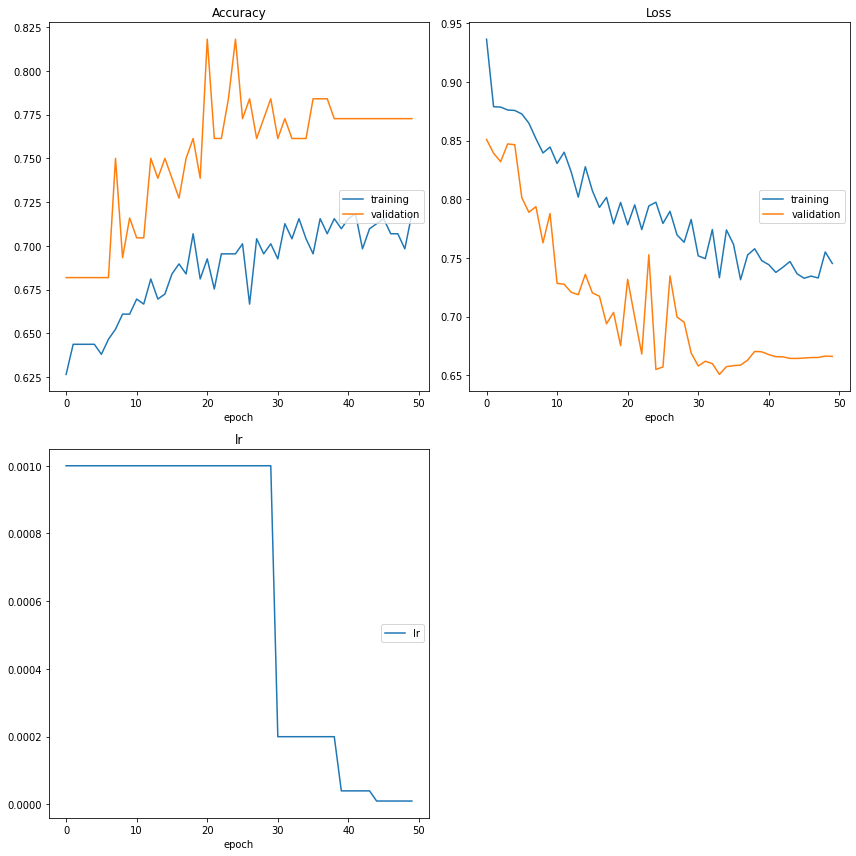

Accuracy
	training         	 (min:    0.626, max:    0.718, cur:    0.718)
	validation       	 (min:    0.682, max:    0.818, cur:    0.773)
Loss
	training         	 (min:    0.731, max:    0.937, cur:    0.745)
	validation       	 (min:    0.651, max:    0.851, cur:    0.666)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)


In [ ]:
max_patience = 50
max_epochs = 50
max_batch = 32

early_stopping = EarlyStopping(monitor='val_acc', patience = max_patience, verbose=0, mode='max', restore_best_weights=False)
callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.00001),early_stopping,PlotLossesKeras()]

print("Training started..")
history = model.fit(X_train, y_train,validation_split=0.2, batch_size=max_batch,epochs=max_epochs,verbose=1,callbacks=callbacks)

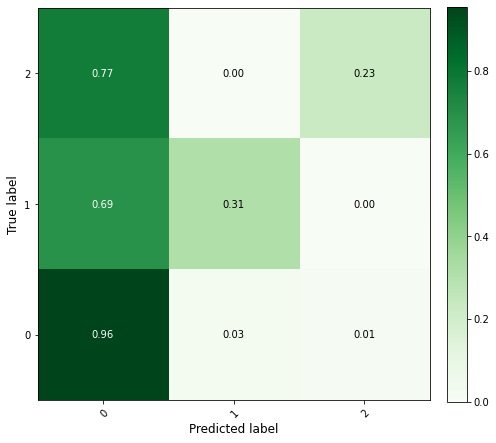

In [ ]:

pred = model.predict(X_test)
pr = [np.argmax(pred[i]) for i in range(len(y_test))]
Y = [np.argmax(y_test[i]) for i in range(len(y_test))]

# for i in range(len(y_test)):
#     pred.append(np.argmax(m.predict(x_test[i])))
#     Y.append(np.argmax(y_test[i]))

conf_plotter(Y , pr , [0,1,2] , normalize=1, cmap = plt.cm.Greens ,mode='test', save=0 , name='RawData_Deep.png')

#training an other network

In [ ]:
print (f"Labels shape: {y.shape}")
print (f"Data size of the array: {y.size}\n" )
print (f"Audio data shape: {X.shape}" )
print (f"Data size of the array: {X.size}\n" )
print (f"Training data shape: {X_train.shape}")
print (f"Training label shape: {y_train.shape}\n" )
print (f"Validation data shape: {X_test.shape}")
print (f"Validation label shape: {y_test.shape}")

In [212]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(Bidirectional(LSTM(units=64, dropout=0.2, return_sequences=True), input_shape=(286,1)))
model.add(Bidirectional(LSTM(units=32, dropout=0.5, return_sequences=True)))

model.add(Bidirectional(LSTM(units=16, dropout=0.5, return_sequences=False)))

model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [213]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 286, 128)          33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 286, 64)           41216     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 85,508
Trainable params: 85,508
Non-trainable params: 0
_________________________________________________________________


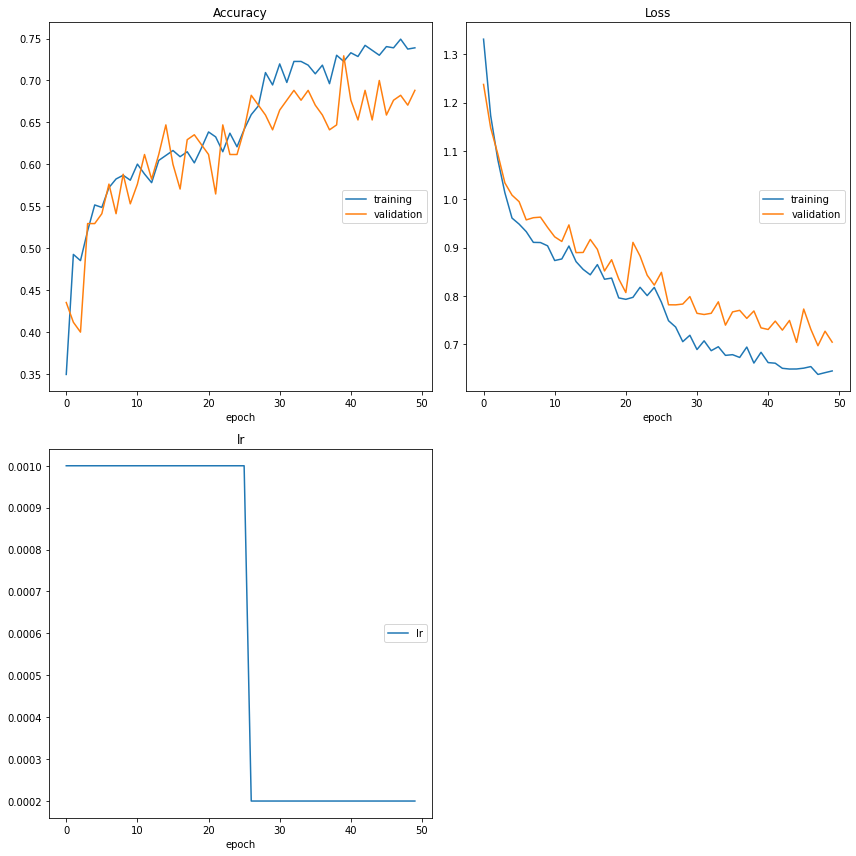

Accuracy
	training         	 (min:    0.350, max:    0.749, cur:    0.739)
	validation       	 (min:    0.400, max:    0.729, cur:    0.688)
Loss
	training         	 (min:    0.637, max:    1.331, cur:    0.645)
	validation       	 (min:    0.697, max:    1.238, cur:    0.704)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)


In [214]:
max_patience = 50
max_epochs = 50
max_batch = 32

early_stopping = EarlyStopping(monitor='val_acc', patience = max_patience, verbose=0, mode='max', restore_best_weights=False)
callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2 ,patience=5 , min_lr=0.00001),early_stopping,PlotLossesKeras()]

print("Training started..")
history = model.fit(X_train, y_train,validation_split=0.2, batch_size=max_batch,epochs=max_epochs,verbose=1,callbacks=callbacks)

In [ ]:
max_patience = 50
max_epochs = 50
max_batch = 32

early_stopping = EarlyStopping(monitor='val_acc', patience = max_patience, verbose=0, mode='max', restore_best_weights=False)
callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.00001),early_stopping,PlotLossesKeras()]

print("Training started..")
history = model.fit(X_train, y_train,validation_split=0.2, batch_size=max_batch,epochs=max_epochs,verbose=1,callbacks=callbacks)

In [ ]:
# model.save("/content/drive/MyDrive/Model/LSTM_245.h5")

In [215]:

results = model.evaluate(X_train, y_train) 
print ("Model training score: ")
print(f"   Train loss = {results[0]} \n   Train acc = {results[1]}")

score = model.evaluate(X_test, y_test) 
print ("Model testing score: ")
print(f"   Test loss = {score[0]} \n   Test acc = {score[1]}")

27/27 [==============================] - 3s 125ms/step - loss: 0.5986 - acc: 0.7759
Model training score: 
   Train loss = 0.5985739827156067 
   Train acc = 0.775943398475647
7/7 [==============================] - 1s 120ms/step - loss: 0.6593 - acc: 0.7512
Model testing score: 
   Test loss = 0.6593112349510193 
   Test acc = 0.751173734664917


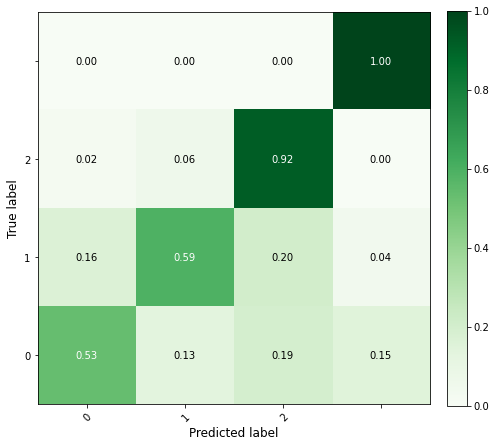

In [216]:

pred = model.predict(X_test)
pr = [np.argmax(pred[i]) for i in range(len(y_test))]
Y = [np.argmax(y_test[i]) for i in range(len(y_test))]

# for i in range(len(y_test)):
#     pred.append(np.argmax(m.predict(x_test[i])))
#     Y.append(np.argmax(y_test[i]))

conf_plotter(Y , pr , [0,1,2] , normalize=1, cmap = plt.cm.Greens ,mode='test', save=0 , name='RawData_Deep.png')

In [217]:
model.save("/content/drive/MyDrive/Model/LSTM_AUG2.h5")

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.layers import Conv2DTranspose ,Conv1DTranspose
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dense , Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import Adam , SGD

In [ ]:
tf.keras.backend.clear_session()



m = Sequential()
m.add(Conv1D(32,
                input_shape=[245, 1],
                kernel_size=40,
                strides=4,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))

m.add(BatchNormalization())
m.add(Activation('relu'))
# m.add(Dropout(0.3))

m.add(MaxPooling1D(pool_size=2, strides=None))
m.add(Conv1D(32,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))

m.add(BatchNormalization())
m.add(Activation('relu'))
# m.add(Dropout(0.3))

m.add(MaxPooling1D(pool_size=2, strides=None))
m.add(Conv1D(64,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))

m.add(MaxPooling1D(pool_size=1, strides=None))
m.add(Conv1D(128,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))

m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=1, strides=None))
m.add(Dropout(0.5))

m.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
m.add(Dense(len_classes, activation='softmax'))

In [ ]:
m.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Adam(learning_rate=0.001)

In [ ]:
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, min_lr=0.0001, verbose=1)
batch_size = 16

m.fit(x=X_train,
            y=y_train,
            batch_size=batch_size,
            epochs=50,
            verbose=1,
            shuffle=True,
            validation_split=0.2)
            # callbacks=[reduce_lr])


In [ ]:

results = m.evaluate(X_train, y_train) 
print ("Model training score: ")
print(f"   Train loss = {results[0]} \n   Train acc = {results[1]}")

score = m.evaluate(X_test, y_test) 
print ("Model testing score: ")
print(f"   Test loss = {score[0]} \n   Test acc = {score[1]}")

14/14 [==============================] - 0s 2ms/step - loss: 1.1906 - accuracy: 0.2294
Model training score: 
   Train loss = 1.1906094551086426 
   Train acc = 0.2293577939271927
4/4 [==============================] - 0s 4ms/step - loss: 1.1731 - accuracy: 0.2661
Model testing score: 
   Test loss = 1.1731324195861816 
   Test acc = 0.26605504751205444


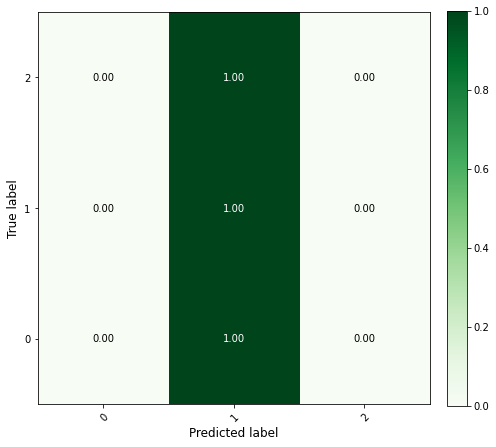

In [ ]:

pred = m.predict(X_test)
pr = [np.argmax(pred[i]) for i in range(len(y_test))]
Y = [np.argmax(y_test[i]) for i in range(len(y_test))]

# for i in range(len(y_test)):
#     pred.append(np.argmax(m.predict(x_test[i])))
#     Y.append(np.argmax(y_test[i]))

conf_plotter(Y , pr , [0,1,2] , normalize=1, cmap = plt.cm.Greens ,mode='test', save=0 , name='RawData_Deep.png')

In [ ]:
from keras.layers import Input
def build_model(input_layer, start_neurons):
    conv1 = Conv1D(start_neurons * 1, 3, activation="relu", padding="same")(input_layer)
    conv1 = Conv1D(start_neurons * 1, 3, activation="relu", padding="same")(conv1)
    pool1 = MaxPooling1D(2)(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv1D(start_neurons * 2, 3, activation="relu", padding="same")(pool1)
    conv2 = Conv1D(start_neurons * 2, 3, activation="relu", padding="same")(conv2)
    pool2 = MaxPooling1D(1)(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv1D(start_neurons * 4, 3, activation="relu", padding="same")(pool2)
    conv3 = Conv1D(start_neurons * 4, 3, activation="relu", padding="same")(conv3)
    pool3 = MaxPooling1D(2)(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv1D(start_neurons * 8, 3, activation="relu", padding="same")(pool3)
    conv4 = Conv1D(start_neurons * 8, 3, activation="relu", padding="same")(conv4)
    pool4 = MaxPooling1D(1)(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv1D(start_neurons * 16, 3, activation="relu", padding="same")(pool4)
    convm = Conv1D(start_neurons * 16, 3, activation="relu", padding="same")(convm)
    
    deconv4 = Conv1DTranspose(start_neurons * 8, 3, strides=1, padding="same")(convm)
    # uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(deconv4)
    uconv4 = Conv1D(start_neurons * 8, 3, activation="relu", padding="same")(uconv4)
    uconv4 = Conv1D(start_neurons * 8, 3, activation="relu", padding="same")(uconv4)

    deconv3 = Conv1DTranspose(start_neurons * 4, 3, strides=1, padding="same")(uconv4)
    # uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(deconv3)
    uconv3 = Conv1D(start_neurons * 4, 3, activation="relu", padding="same")(uconv3)
    uconv3 = Conv1D(start_neurons * 4, 3, activation="relu", padding="same")(uconv3)

    deconv2 = Conv1DTranspose(start_neurons * 2, 3, strides=2, padding="same")(uconv3)
    # uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(deconv2)
    uconv2 = Conv1D(start_neurons * 2, 3, activation="relu", padding="same")(uconv2)
    uconv2 = Conv1D(start_neurons * 2, 3, activation="relu", padding="same")(uconv2)

    deconv1 = Conv1DTranspose(start_neurons * 1, 3, strides=2, padding="same")(uconv2)
    # uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(deconv1)
    uconv1 = Conv1D(start_neurons * 1, 3, activation="relu", padding="same")(uconv1)
    uconv1 = Conv1D(start_neurons * 1, 2, activation="relu", padding="same")(uconv1)
    
    output_layer = Conv1D(3, 1, padding="same", activation="softmax")(uconv1)
    
    return output_layer

input_layer = Input((97, 1))
output_layer = build_model(input_layer, 16)


In [ ]:
from keras.models import Model
m2 = Model(input_layer,output_layer)

In [ ]:
m2.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Adam(learning_rate=0.001)

In [ ]:
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, min_lr=0.0001, verbose=1)
batch_size = 10

m2.fit(x=X_train,
            y=y_train,
            batch_size=batch_size,
            epochs=50,
            verbose=1,
            shuffle=True,
            validation_split=0.2)
            # callbacks=[reduce_lr])

Epoch 1/50


ValueError: ignored

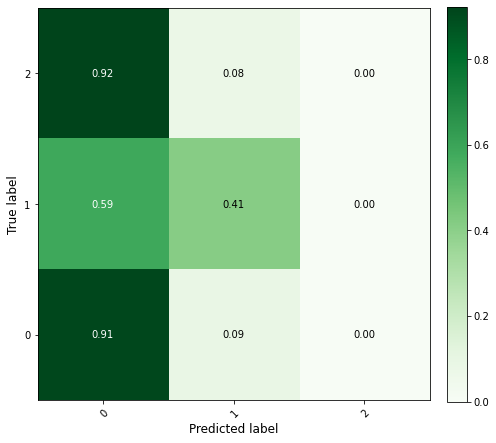

In [ ]:

pred = m.predict(X_test)
pr = [np.argmax(pred[i]) for i in range(len(y_test))]
Y = [np.argmax(y_test[i]) for i in range(len(y_test))]

# for i in range(len(y_test)):
#     pred.append(np.argmax(m.predict(x_test[i])))
#     Y.append(np.argmax(y_test[i]))

conf_plotter(Y , pr , [0,1,2] , normalize=1, cmap = plt.cm.Greens ,mode='test', save=0 , name='RawData_Deep.png')